# Proposed project (Masoud)¶

### This notebook allows you to fetch a channel from multi-channel OME file stored in DSA servers.

### The code plot the channel histogram, boxplot and extract the features

In [1]:
import large_image
from io import StringIO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import girder_client
import os,sys,json,io

## Login to DSA server

In [2]:
# Server api link
base_url = "https://styx.neurology.emory.edu/girder/api/v1/"

gc = girder_client.GirderClient(apiUrl = base_url)

# Create account on DSA at https://styx.neurology.emory.edu/girder/  
# Use your account to login
gc.authenticate( username="user",
    password="password",)



{u'_accessLevel': 2,
 u'_id': u'5fa4b018660f1f265e405ae4',
 u'_modelType': u'user',
 u'admin': False,
 u'created': u'2020-11-06T02:08:24.480000+00:00',
 u'email': u'a@b.com',
 u'emailVerified': False,
 u'firstName': u'first_name',
 u'groupInvites': [],
 u'groups': [],
 u'lastName': u'last_name',
 u'login': u'user',
 u'otp': False,
 u'public': True,
 u'size': 0,
 u'status': u'enabled'}

## Find a channel number for the ome-tiff item id given

In [3]:
# Multichannel OME-tiff file id  on Styx server
item_id = "5e361da534679044bda81b16"
itemInfo =  gc.get( "item/" + item_id, jsonResp=True);

# Channel Name to fetch
frame_name = "DNA 1";

for channel in itemInfo['meta']['omeSceneDescription']:
    print (channel["channel_number"], channel["channel_name"]);
    if frame_name == channel["channel_name"]:
        frame_num = channel["channel_number"];
        

print("channel number for {} is {}".format(frame_name, frame_num))        

(0, u'DNA 1')
(1, u'A488 background')
(2, u'A555 background')
(3, u'A647 background')
(4, u'DNA 2')
(5, u'A488 background')
(6, u'A555 background')
(7, u'A647 background')
(8, u'DNA 3')
(9, u'A488 background')
(10, u'LAG3')
(11, u'ARL13B')
(12, u'DNA 4')
(13, u'KI67')
(14, u'KERATIN')
(15, u'PD1')
(16, u'DNA 5')
(17, u'CD45RB')
(18, u'CD3D')
(19, u'PDL1')
(20, u'DNA 6')
(21, u'CD4')
(22, u'CD45')
(23, u'CD8A')
(24, u'DNA 7')
(25, u'CD163')
(26, u'CD68')
(27, u'CD14')
(28, u'DNA 8')
(29, u'CD11B')
(30, u'FOXP3')
(31, u'CD21')
(32, u'DNA 9')
(33, u'IBA1')
(34, u'ASMA')
(35, u'CD20')
(36, u'DNA 10')
(37, u'CD19')
(38, u'GFAP')
(39, u'GTUBULIN')
(40, u'DNA 11')
(41, u'LAMINAC')
(42, u'BANF1')
(43, u'LAMINB')
channel number for DNA 1 is 0


## Read the channel from the server

In [4]:
# DSA API to read the remote channel
request_url = "item/" + item_id + "/tiles/region?units=base_pixels&exact=false&frame=" + str(frame_num) + "&encoding=JPEG&jpegQuality=95&jpegSubsampling=0"
response = gc.get( request_url, jsonResp=False)
image_raw = Image.open(io.BytesIO(response.content))
image = np.array(image_raw)

In [5]:
# monitor memory usage
# !watch -n 5 free -h


## Check whether is the channel is gray scale

In [6]:
def is_gray_scale(image):
    if len(image.shape) > 2:
        if (np.array_equal(image[:,:,0], image[:,:,1])) and (np.array_equal(image[:,:,0], image[:,:,2])):  
            return True
        else:
            return False
    else:
        return True

In [7]:
is_gray_scale(image)

True

## Get channel image information 

In [8]:
print('Image shape    : {}'.format(image.shape))
print('Image Dimension    : {}'.format(len(image.shape)))
print('Image Height       : {}'.format(image.shape[0]))
print('Image Width        : {}'.format(image.shape[1]))

if not is_gray_scale(image):
    channels = image.shape[2]
    print('Number of Channels : {}'.format(channels))

print('Image max value       : {}'.format(image.max()))
print('Image min value       : {}'.format(image.min()))


Image shape    : (16125, 16843)
Image Dimension    : 2
Image Height       : 16125
Image Width        : 16843
Image max value       : 255
Image min value       : 0


## Show channel 

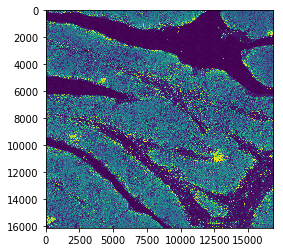

In [9]:
image_height =  image.shape[0]
image_width =  image.shape[1]
plt.imshow(image[ 0 : image_height, 0 : image_width ])

## Show channel region

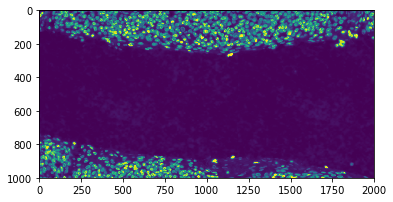

In [10]:
plt.imshow(image[0:1000, 0:2000])  # max is image []

## Show channel intensity histogram

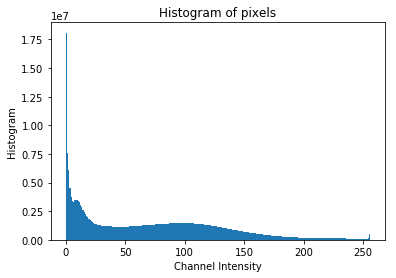

In [11]:
num_bins = 256;
fig, ax = plt.subplots()
ax.hist(image.ravel(),num_bins,[0,256]) 
ax.set_xlabel('Channel Intensity')
ax.set_ylabel('Histogram')
ax.set_title(r'Histogram of pixels')

plt.show() 

## Show boxplot of the channel

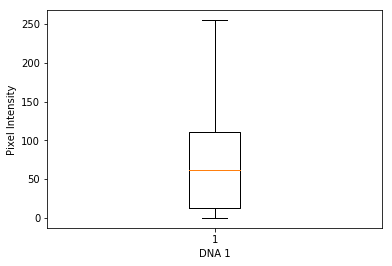

In [12]:
fig, ax = plt.subplots()
ax.boxplot(image.ravel())
ax.set_xlabel(frame_name)
ax.set_ylabel("Pixel Intensity")
plt.show() 

## Create tiles for the channel image and get the features for each tile

In [13]:
# Get channel dim
image_width, image_height = image_raw.size 

# tile width to partition the channel 
tile_width = 32

# current channel name
channel_name = "DNA"

# output json file for tiles features
out_json_file = channel_name + "_Grid_"+ str(tile_width) + "_Feat.json"

# Dictionaries to store features
tiles_data = []
tile_points = [] 

# To count created tiles
tiles_counter = 0

# Parameters for edge tiles
diff_width = 0;
diff_height = 0; 

total_tiles = math.ceil(float(image_width) / tile_width) * math.ceil(float(image_height) / tile_width);

print(" channel total_tiles : {}".format(total_tiles))

# Loop to get tiles features

for i in range( int( math.ceil( float(image_height) / tile_width ) ) ):  
      for j in range( int( math.ceil( float(image_width) / tile_width ) ) ):
            tiles_counter += 1;
            if(((i + 1) * tile_width) > image_height) :
                  diff_height = ( (i + 1) * tile_width ) - image_height;
            else :
                  diff_height = 0;
            

            if(((j + 1) * tile_width) > image_width) :
                  diff_width = ( (j + 1) * tile_width ) - image_width;
            else :
                  diff_width = 0;                
                        
            tile_points = str(i * tile_width) + "," + str(j * tile_width) + " " + str(i * tile_width) + "," + str(((j + 1) * tile_width) - diff_width) + " " + str(((i + 1) * tile_width) - diff_height) + "," + str(((j + 1) * tile_width) - diff_width) + " " + str(((i + 1) * tile_width) - diff_height) + "," + str((j) * tile_width) + " " +  str(i * tile_width) + "," + str(j * tile_width);
            imgTile = image[i * tile_width : ((i+1) * tile_width) - diff_height , j * tile_width : ((j+1) * tile_width) - diff_width ];
            tile_mean = np.mean(imgTile, axis = (0, 1));
            tile_std = np.std(imgTile, axis = (0, 1));
            tile_max = np.max(imgTile, axis = (0, 1));
            
            tiles_data.append({"label": "grid-"+str(j) + "-" + str(i), "mean": tile_mean.tolist(), "max": tile_max.tolist(), "std": tile_std.tolist(), "TileBoundaries":tile_points  })


print('Number of tiles = {}'.format(tiles_counter))
# print( 'Tile Data = {}'.format(tiles_data))

# Create Json file 
with open(out_json_file, 'w') as f:
    json.dump(tiles_data, f)

 channel total_tiles : 265608.0
Number of tiles = 265608


## Convert dictionary to dataFrame

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(tiles_data)
df.head()

## Get tile with maximum mean 

In [ ]:
df.loc[df['mean'] == df['mean'].max()]

## Get all tiles with zero signal

In [ ]:
df.loc[df['max'] == 0]

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();